In [1]:
import pandas as pd 
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
session = "back_only_act_only2"
runs = api.runs(f"tony_t_liu/{session}")


meta_data = {
    "batch_size": [],
    "act_man_width": [],
    "weight_man_width": [],
    "same_input": [],
    "act_rounding": [],
    "back_man_width": []
}

stat_data = {
    # "lr": [],
    # "test_acc": [],
    # "test_loss": [],
    # "grad_norm_entire": [],
    # "grad_norm_entire_ema": [],
    # "lp_grad_norm": [],
    "full_grad_norm": [],
}

for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    for key in stat_data:
        if key in run.summary._json_dict:
            stat_data[key].append(run.summary._json_dict[key])
        else:
            stat_data[key].append(None)

    for key in meta_data:
        if key in run.config:
            meta_data[key].append(run.config[key])
        else:
            meta_data[key].append(None)

runs_df = pd.DataFrame(meta_data | stat_data)


In [2]:
# pad none id with empty string
# runs_df["same_input"].fillna(False, inplace=True)
# # runs_df[runs_df["back_man_width"] == None] = runs_df["act_man_width"]
# runs_df["back_man_width"].fillna(runs_df["act_man_width"], inplace=True)

runs_df

,batch_size,act_man_width,weight_man_width,same_input,act_rounding,back_man_width,full_grad_norm
0,80,23,23,None,None,23,0.021542
1,80,23,23,None,None,23,0.022025
2,80,23,23,None,None,23,0.006197
3,80,23,23,None,None,23,0.010554
4,160,23,23,None,None,23,0.043388
5,160,23,23,None,None,23,0.007609
6,160,23,23,None,None,23,0.024184
7,160,23,23,None,None,23,0.033964
8,320,23,23,None,None,23,0.013181
9,320,23,23,None,None,23,0.024091


In [31]:
#runs_df = runs_df.groupby(["batch_size", "weight_man_width", "act_man_width", "method", "lr"]).mean().reset_index()
runs_df = runs_df.groupby(["batch_size", "weight_man_width", "act_man_width", "act_rounding", "back_man_width", "same_input"]).mean().reset_index()
import numpy as np
# runs_df["lr"] = runs_df["lr"].astype(np.float32)
runs_df.to_csv(f"../out/result_tables/{session}.csv")

In [32]:
runs_df

,batch_size,weight_man_width,act_man_width,act_rounding,back_man_width,same_input,full_grad_norm


In [33]:
runs_df["lr"].unique()

KeyError: 'lr'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.backends
%matplotlib inline 
import matplotlib.pyplot as plt


def make_plot(df, dir, levels=10):
    # df = df.drop(columns=["method"])
    grouped_df = df.groupby(['act_man_width', 'batch_size']).mean().reset_index()
    df_avg = grouped_df
    # Pivot the data to create a grid for the contour plot
    pivot_table = df_avg.pivot_table(index='batch_size', columns='act_man_width', values='grad_norm_entire_ema')

    # Create a meshgrid for the contour plot
    X, Y = np.meshgrid(pivot_table.columns, pivot_table.index)
    Z = pivot_table.values

    print(pivot_table.shape)
    print(pivot_table)

    # Pad the surrounding of Z with the same value as the edge (pad on the beginning side)
    Z = np.pad(Z, ((1, 0), (1, 0)), mode='edge')
    print(X.shape, Y.shape, Z.shape)

    # Update meshgrid to match the padded Z
    X, Y = np.meshgrid(
        np.insert(pivot_table.columns, 0, pivot_table.columns[0] - 1), 
        np.insert(pivot_table.index, 0, pivot_table.index[0] - 1)
    )

    # Create a 2D contour plot
    plt.figure(figsize=(10, 8))
    cp = plt.contourf(X, Y, Z, levels=levels)
    plt.colorbar(cp, label='Norm')

    # Set the y-axis to log scale if needed
    # plt.yscale('log')  # Uncomment this line if the y-axis should be in log scale

    # Labeling the axes
    plt.xlabel('Mantissa Width')
    plt.ylabel('Batch Size')
    lr = df['lr'].iloc[0]
    plt.savefig(f"{dir}/{lr}.png")


In [ ]:
# runs_df = pd.read_csv("../out/result_tables/c.csv")

In [ ]:
make_plot(runs_df_m, "../out/result_images/mnist_cnn")


NameError: name 'runs_df_m' is not defined

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def line_plot(df, dir):
    # Create the plot
    plt.figure(figsize=(10, 8))
    print(df)
    plt.plot(df['batch_size'], df['grad_norm_entire'], marker='o', linestyle='-', color='b')

    # Adding labels and title
    plt.xlabel('Batch Size')
    plt.ylabel('Average Gradient Norm')
    plt.title('Gradient Norm vs. Batch Size for Mantissa Width 1')
    plt.grid(True)

    # Optionally, set the x-axis to log scale if the batch sizes are not uniformly distributed
    # plt.xscale('log')

    # Save the plot
    lr = df['lr'].iloc[0]  # Assuming learning rate 'lr' is constant across the DataFrame
    plt.savefig(f"{dir}/gradient_norm_vs_batch_size_{lr}.png")

    # Show the plot if you are running this in an interactive environment (optional)
    plt.show()


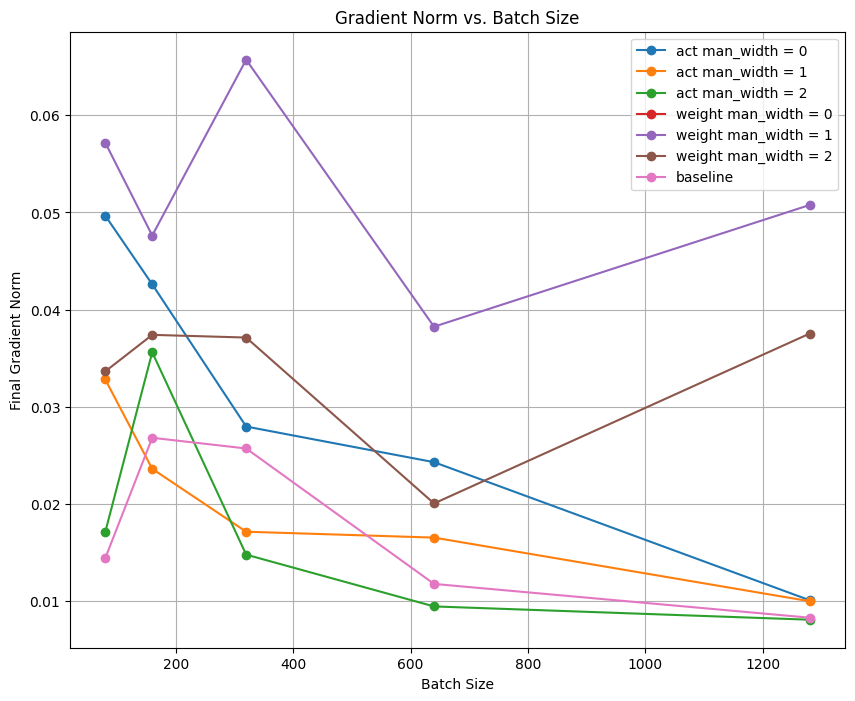

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# is_same_input = (runs_df["same_input"] == True)
# def back_man(i):
#     return runs_df["back_man_width"] == i
runs_df = runs_df[runs_df["batch_size"] != 1]


def plot(l: pd.DataFrame, label):
    plt.plot(l['batch_size'], l['full_grad_norm'], marker='o', linestyle='-', label=label)

# # Loop through each man_width and plot lines for both data frames
# for i in [0, 1]:
#     act_df = runs_df[act_man(i) & weight_man(23)]
#     # actlow = act_df[rounding("stochastic") & back_man(i) & ~is_same_input]
#     # actlow_nearest = act_df[rounding("nearest") & back_man(i)]
#     # actlow_same = act_df[rounding("stochastic") & is_same_input]
#     # back_man = runs_df[rounding("stochastic") & act_man(i) & back_man(23) & ~is_same_input]
#     plot(act_df, f"man_width = {i}")
#     # plot(actlow_nearest, f"man_width = {i}, rounding = nearest,")
#     # plot(actlow_same, f"man_width = {i}, rounding = stochastic, same_input = True")
#     # plot(back_man, f"man_width = {i}, rounding = stochastic, back=23")

df1 = runs_df[['weight_man_width', 'act_man_width', 'batch_size', 'full_grad_norm']]

df2 = df1.groupby(['weight_man_width', 'act_man_width', 'batch_size']).mean().reset_index()
def act_man(i):
    return df2["act_man_width"] == i
# def rounding(i):
#     return runs_df["act_rounding"] == i
def weight_man(i):
    return df2["weight_man_width"] == i

for i in [0, 1, 2]:
    act_df = df2[act_man(i) & weight_man(23)]
    # actlow = act_df[rounding("stochastic") & back_man(i) & ~is_same_input]
    # actlow_nearest = act_df[rounding("nearest") & back_man(i)]
    # actlow_same = act_df[rounding("stochastic") & is_same_input]
    # back_man = runs_df[rounding("stochastic") & act_man(i) & back_man(23) & ~is_same_input]
    plot(act_df, f"act man_width = {i}")
    # plot(actlow_nearest, f"man_width = {i}, rounding = nearest,")
    # plot(actlow_same, f"man_width = {i}, rounding = stochastic, same_input = True")
    # plot(back_man, f"man_width = {i}, rounding = stochastic, back=23")

for i in [0, 1, 2]:
    act_df = df2[act_man(23) & weight_man(i)]
    # actlow = act_df[rounding("stochastic") & back_man(i) & ~is_same_input]
    # actlow_nearest = act_df[rounding("nearest") & back_man(i)]
    # actlow_same = act_df[rounding("stochastic") & is_same_input]
    # back_man = runs_df[rounding("stochastic") & act_man(i) & back_man(23) & ~is_same_input]
    plot(act_df, f"weight man_width = {i}")

act_df = df2[act_man(23) & weight_man(23)]
# actlow = act_df[rounding("stochastic") & back_man(i) & ~is_same_input]
# actlow_nearest = act_df[rounding("nearest") & back_man(i)]
# actlow_same = act_df[rounding("stochastic") & is_same_input]
# back_man = runs_df[rounding("stochastic") & act_man(i) & back_man(23) & ~is_same_input]
plot(act_df, f"baseline")

# base_line = runs_df[(runs_df["weight_man_width"] == 23) & (runs_df["act_man_width"] == 23)]
# plt.plot(base_line['batch_size'], base_line['full_grad_norm'], marker='o', linestyle='-', label='base line')


# Adding labels and title
plt.xlabel('Batch Size')
plt.ylabel('Final Gradient Norm')
plt.title('Gradient Norm vs. Batch Size')
plt.grid(True)

# Adding the legend
plt.legend()

# Optionally, set the x-axis to log scale if the batch sizes are not uniformly distributed
# plt.xscale('log')

plt.show()
